###### Importation

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

###### GLOBAL VARIABLES

In [41]:
SEED = 8
OUT = 'co2'
OUTPUTS = ['co2','no','no2','pm10','pm2.5','humi','temp']
USE_FREQ = False
USE_SLIDING_WINDOW = False
USE_ROLLING_MEAN = False
SKIP_PLOT = False

###### DATA OPENING

In [3]:
data = pd.read_csv('all_data.csv')

In [4]:
data.head()

,co2,humi,no,no2,pm10,pm2.5,station,temp,date,time,...,1,11,14,3,4,7,8,9,a,b
0,403.0,51.2,NaN,NaN,295.0,118.0,auber,20.4,2013-01-01,10:00:00,...,0.0,0.0,0.0,777.0,0.0,331.0,339.0,402.0,95.0,0.0
1,767.0,46.4,99.0,54.0,362.0,110.0,auber,18.3,2013-01-15,10:00:00,...,0.0,0.0,0.0,777.0,0.0,331.0,339.0,402.0,95.0,0.0
2,495.0,45.0,68.0,45.0,117.0,36.0,auber,18.7,2013-01-12,10:00:00,...,0.0,0.0,0.0,777.0,0.0,331.0,339.0,402.0,95.0,0.0
3,708.0,45.3,90.0,40.0,234.0,73.0,auber,19.5,2013-01-09,10:00:00,...,0.0,0.0,0.0,777.0,0.0,331.0,339.0,402.0,95.0,0.0
4,749.0,41.8,213.0,62.0,314.0,112.0,auber,17.5,2013-01-16,10:00:00,...,0.0,0.0,0.0,777.0,0.0,331.0,339.0,402.0,95.0,0.0


###### Missing data

In [5]:
for col in data.columns:
    print("missing data in {} : {} i.e. {}%".format(col,len(data[data[col].isnull()]),
                                                       len(data[data[col].isnull()])/float(len(data))*100))

missing data in co2 : 9585 i.e. 9.11841091355347%
missing data in humi : 4409 i.e. 4.194373888143687%
missing data in no : 20924 i.e. 19.905438701637223%
missing data in no2 : 12155 i.e. 11.563305649894879%
missing data in pm10 : 7853 i.e. 7.470723099022994%
missing data in pm2.5 : 73562 i.e. 69.98106871390927%
missing data in station : 0 i.e. 0.0%
missing data in temp : 4424 i.e. 4.208643701779921%
missing data in date : 0 i.e. 0.0%
missing data in time : 0 i.e. 0.0%
missing data in precipitation : 144 i.e. 0.13699021090784552%
missing data in temp_min : 144 i.e. 0.13699021090784552%
missing data in temp_max : 144 i.e. 0.13699021090784552%
missing data in holiday : 0 i.e. 0.0%
missing data in celebration : 0 i.e. 0.0%
missing data in 1 : 0 i.e. 0.0%
missing data in 11 : 0 i.e. 0.0%
missing data in 14 : 0 i.e. 0.0%
missing data in 3 : 0 i.e. 0.0%
missing data in 4 : 0 i.e. 0.0%
missing data in 7 : 0 i.e. 0.0%
missing data in 8 : 0 i.e. 0.0%
missing data in 9 : 0 i.e. 0.0%
missing data 

Top three missing data columns :  
-no  
-pm10  
-pm2.5  
-co2

#### Date & Time processing

In [6]:
data['datetime'] = data['date'].str.cat(data['time'].astype(str), sep = ' ')

In [7]:
data['datetime'] = pd.to_datetime(data['datetime'], format = '%Y-%m-%d %H:%M:%S')

In [8]:
data['year'],data['month'],data['day'] = data["date"].str.split("-").str
data['year'] = data['year'].astype(int)
data['month'] = data['month'].astype(int)
data['day'] = data['day'].astype(int)

In [9]:
data['hour'],data['minute'],data['second'] = data["time"].str.split(":").str
data['hour'] = data['hour'].astype(int)
data['minute'] = data['minute'].astype(int)
data['second'] = data['second'].astype(int)

In [10]:
data = data.drop(labels = ['minute','second'], axis = 1)

In [11]:
data['date'] = pd.to_datetime(data['date'], format = "%Y-%m-%d")

In [12]:
data['week'] = data['date'].dt.week

In [13]:
data['weekday'] = data['date'].dt.dayofweek

In [14]:
data['time'] = pd.to_datetime(data['time'], format = "%H:%M:%S")

In [15]:
data['time'] = data["time"].dt.time

###### Missing data in meteo

There are a couple of missing days in the meteo columns, I propose to take the mean of the previous and past days.

In [16]:
data[data['precipitation'].isnull()]

,co2,humi,no,no2,pm10,pm2.5,station,temp,date,time,...,9,a,b,datetime,year,month,day,hour,week,weekday
1260,446.0,43.2,34.0,73.0,32.0,14.0,auber,17.3,2016-04-30,10:00:00,...,402.0,95.0,0.0,2016-04-30 10:00:00,2016,4,30,10,17,5
1413,609.0,41.8,162.0,88.0,143.0,50.0,auber,25.6,2016-08-31,10:00:00,...,402.0,95.0,0.0,2016-08-31 10:00:00,2016,8,31,10,35,2
2777,477.0,41.6,33.0,67.0,35.0,16.0,auber,17.7,2016-04-30,13:00:00,...,390.0,94.0,0.0,2016-04-30 13:00:00,2016,4,30,13,17,5
2871,486.0,37.2,33.0,92.0,74.0,24.0,auber,25.8,2016-08-31,13:00:00,...,390.0,94.0,0.0,2016-08-31 13:00:00,2016,8,31,13,35,2
4138,526.0,34.3,23.0,102.0,85.0,28.0,auber,26.5,2016-08-31,17:00:00,...,630.0,135.0,0.0,2016-08-31 17:00:00,2016,8,31,17,35,2
4283,530.0,39.4,45.0,81.0,34.0,17.0,auber,17.9,2016-04-30,17:00:00,...,630.0,135.0,0.0,2016-04-30 17:00:00,2016,4,30,17,17,5
5486,507.0,35.0,25.0,106.0,76.0,26.0,auber,26.2,2016-08-31,16:00:00,...,545.0,103.0,0.0,2016-08-31 16:00:00,2016,8,31,16,35,2
5709,506.0,41.5,41.0,78.0,47.0,23.0,auber,17.8,2016-04-30,16:00:00,...,545.0,103.0,0.0,2016-04-30 16:00:00,2016,4,30,16,17,5
7208,404.0,45.3,16.0,59.0,14.0,7.0,auber,17.6,2016-04-30,03:00:00,...,19.0,0.0,0.0,2016-04-30 03:00:00,2016,4,30,3,17,5
7242,409.0,40.2,58.0,84.0,121.0,38.0,auber,25.7,2016-08-31,03:00:00,...,19.0,0.0,0.0,2016-08-31 03:00:00,2016,8,31,3,35,2


In [17]:
for idx in data[data['temp_min'].isnull()].index:
    data.loc[idx,'temp_min'] = (data.loc[idx-1,'temp_min'] + data.loc[idx+1,'temp_min'])/2
for idx in data[data['temp_max'].isnull()].index:
    data.loc[idx,'temp_max'] = (data.loc[idx-1,'temp_max'] + data.loc[idx+1,'temp_max'])/2
for idx in data[data['precipitation'].isnull()].index:
    data.loc[idx,'precipitation'] = (data.loc[idx-1,'precipitation'] + data.loc[idx+1,'precipitation'])/2
for idx in data[data['precipitation'].isnull()].index:
    data.loc[idx,'precipitation'] = (data.loc[idx-1,'precipitation'] + data.loc[idx+1,'precipitation'])/2

###### Missing data in CO2

Let's choose auber because, it is the station with the least missing data


In [18]:
data = data.drop(labels=[x for x in OUTPUTS if x != OUT], axis = 1)

In [19]:
data = data.dropna()

In [20]:
data = data[data['station'] == 'auber']

###### Frequentation
Frequentation is the sum of the trains per hour over all lines

In [21]:
data['frequentation'] = data['a']+data['b']+data['1']+data['11']+data['14']+data['3']+data['4']+data['7']+data['9']

###### Celebration & holidays impact

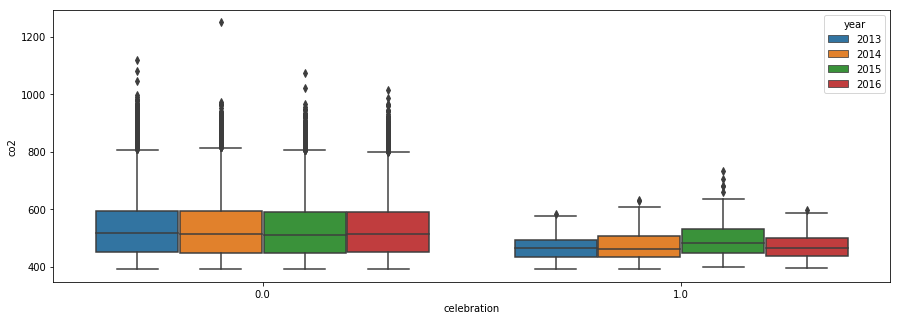

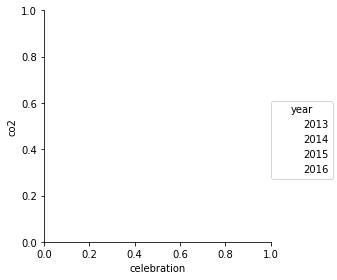

In [22]:
fig, ax = plt.subplots(figsize=(15,5))
sns.factorplot(x="celebration", y=OUT, hue = "year", data=data, kind = "box", ax = ax)

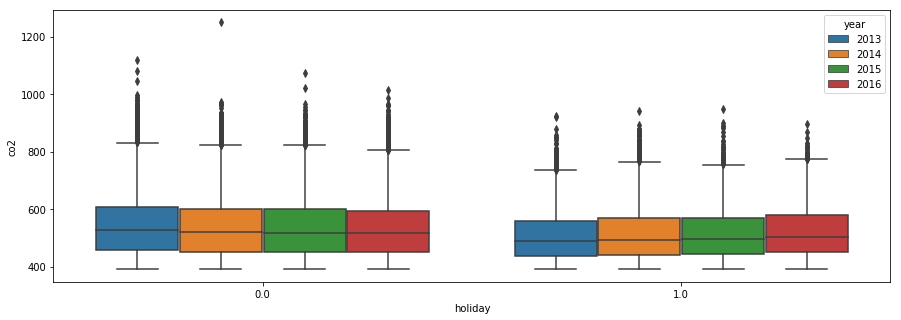

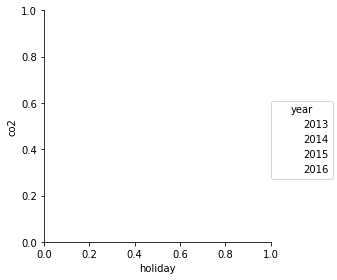

In [23]:
fig, ax = plt.subplots(figsize=(15,5))
sns.factorplot(x="holiday", y=OUT, hue = "year", data=data, kind = "box", ax = ax)

###### Daily visualization

In [24]:
mask = (data['date'] > pd.datetime(2016,1,1)) & (data['date'] <= pd.datetime(2016,1,2))

No handles with labels found to put in legend.


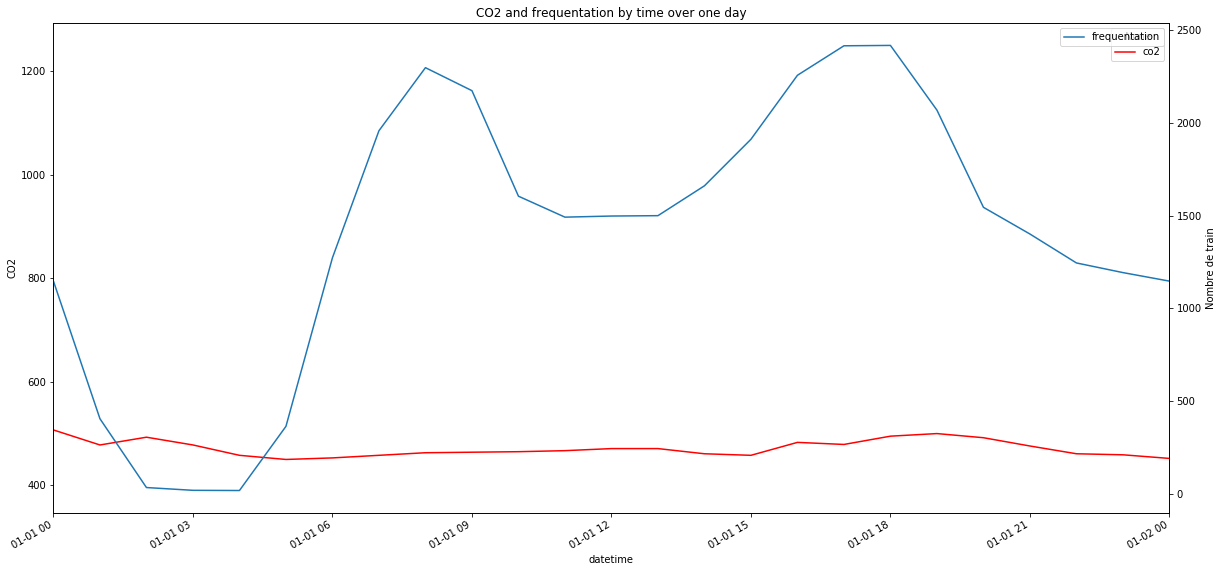

In [25]:
fig, ax1 = plt.subplots(figsize=(20,10))
ax1.set_xlim([pd.datetime(2016,1,1,0),pd.datetime(2016,1,2,0)])
ax1.set_title("CO2 and frequentation by time over one day")
ax1.set_xlabel("Day and Hour")
ax2 = ax1.twinx()
ax1.set_ylabel("CO2")
ax2.set_ylabel("Nombre de train")

ax1.legend(loc=0)
data.plot(x = ['datetime'],y = [OUT], ax = ax1, label = "co2", color = 'red')
data.plot(x = ['datetime'],y = ['frequentation'], ax = ax2, label = "frequentation")

###### Time delay
Adding a time to take in account the forecasting aspect. For visibility purpose, I will focus on year 2013 on January

In [26]:
delay = 24
data[OUT + '_delay'] = data[OUT]
data[OUT + '_delay'] = data[OUT + '_delay'].shift(delay)

In [27]:
data_2013 = data[(data['year'] == 2013) & (data['month'] == 1)]

###### Delayed rolling mean

In [28]:
print(data_2013.columns)
data_2013 = data_2013.set_index(data_2013['datetime'])
data_2013 = data_2013.sort_index()
data_2013[OUT + '_2h'] = data_2013[OUT].rolling(window = '2H',min_periods = 1).mean()
data_2013[OUT + '_3h'] = data_2013[OUT].rolling(window = '3H',min_periods = 1).mean()
data_2013[OUT + '_d'] = data_2013[OUT].rolling(window = '24H',min_periods = 1).mean()
data_2013[OUT + '_w'] = data_2013[OUT].rolling(window = '7d',min_periods = 1).mean()

Index(['co2', 'station', 'date', 'time', 'precipitation', 'temp_min',
       'temp_max', 'holiday', 'celebration', '1', '11', '14', '3', '4', '7',
       '8', '9', 'a', 'b', 'datetime', 'year', 'month', 'day', 'hour', 'week',
       'weekday', 'frequentation', 'co2_delay'],
      dtype='object')


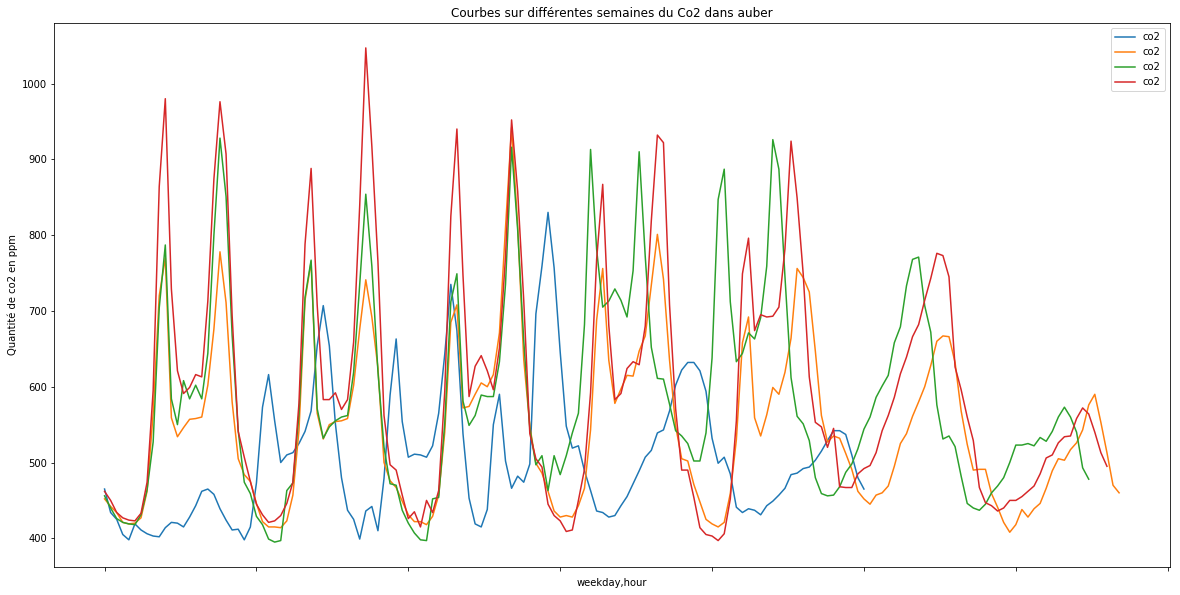

In [29]:
fig, ax = plt.subplots(figsize=(20,10))
ax.set_title("Courbes sur différentes semaines du Co2 dans auber")
ax.set_xlabel("Jour de la semaine et heure")
ax.set_ylabel("Quantité de co2 en ppm")
data_2013[data_2013["week"] == 1].plot(x = ['weekday','hour'],y = OUT, ax = ax)
data_2013[data_2013["week"] == 2].plot(x = ['weekday','hour'],y = OUT, ax = ax)
data_2013[data_2013["week"] == 3].plot(x = ['weekday','hour'],y = OUT, ax = ax)
data_2013[data_2013["week"] == 4].plot(x = ['weekday','hour'],y = OUT, ax = ax)

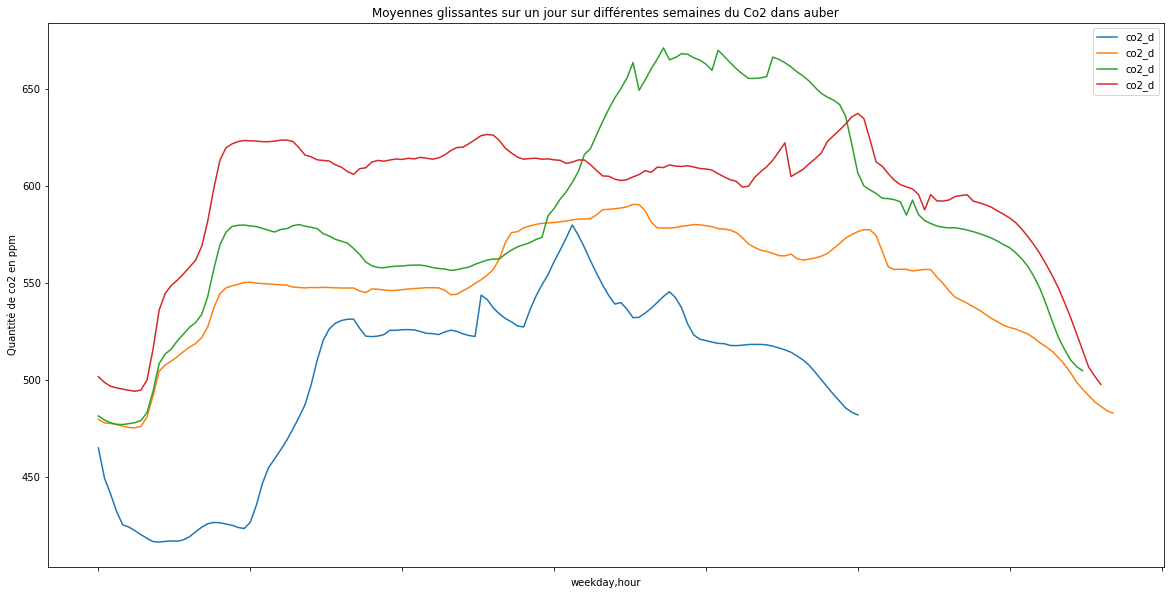

In [30]:
fig, ax = plt.subplots(figsize=(20,10))
ax.set_title("Moyennes glissantes sur un jour sur différentes semaines du Co2 dans auber")
ax.set_xlabel("Jour de la semaine et heure")
ax.set_ylabel("Quantité de co2 en ppm")
data_2013[data_2013["week"] == 1].plot(x = ['weekday','hour'],y = OUT + '_d', ax = ax)
data_2013[data_2013["week"] == 2].plot(x = ['weekday','hour'],y = OUT + '_d', ax = ax)
data_2013[data_2013["week"] == 3].plot(x = ['weekday','hour'],y = OUT + '_d', ax = ax)
data_2013[data_2013["week"] == 4].plot(x = ['weekday','hour'],y = OUT + '_d', ax = ax)

/home/romain/.virtualenvs/python3.6/lib/python3.6/site-packages/pandas/plotting/_core.py:1716: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  series.name = label


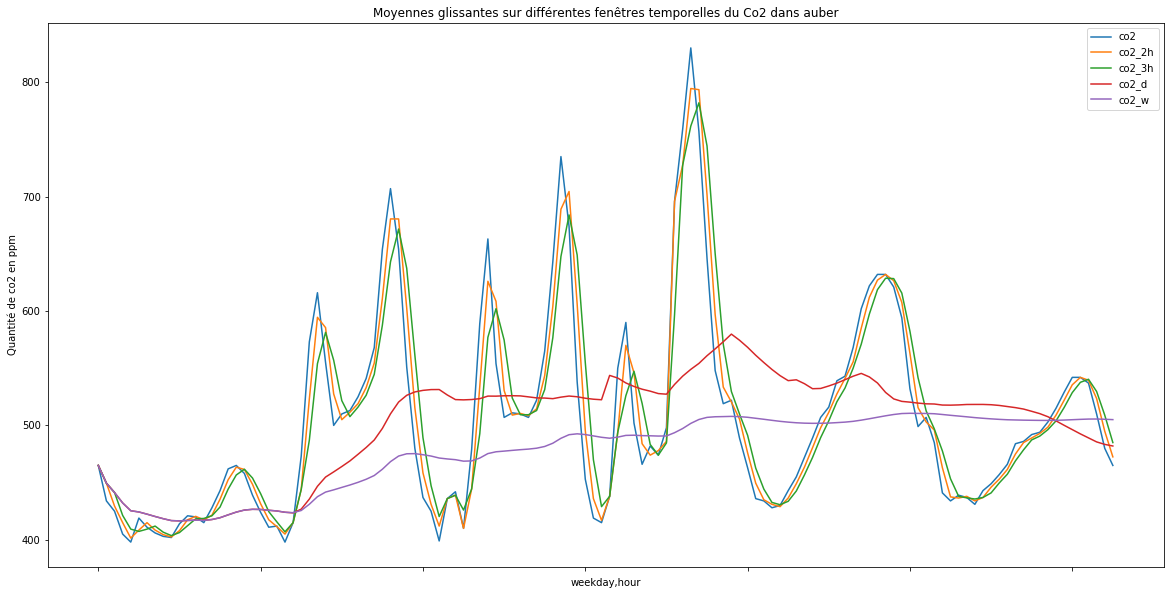

In [31]:
fig, ax = plt.subplots(figsize=(20,10))
ax.set_title("Moyennes glissantes sur différentes fenêtres temporelles du Co2 dans auber")
ax.set_xlabel("Jour de la semaine et heure")
ax.set_ylabel("Quantité de co2 en ppm")
data_2013[data_2013["week"] == 1].plot(x = ['weekday','hour'],y = [OUT,OUT + '_2h',OUT + '_3h',OUT + '_d',OUT + '_w'], ax = ax)

In [32]:
data_2013['err_' + OUT + '_2h'] = data_2013[OUT] - data_2013[OUT + '_2h']
data_2013['err_' + OUT + '_3h'] = data_2013[OUT] - data_2013[OUT + '_3h']
data_2013['err_' + OUT + '_d'] = data_2013[OUT] - data_2013[OUT + '_d']
data_2013['err_' + OUT + '_w'] = data_2013[OUT] - data_2013[OUT + '_w']

/home/romain/.virtualenvs/python3.6/lib/python3.6/site-packages/pandas/plotting/_core.py:1716: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  series.name = label


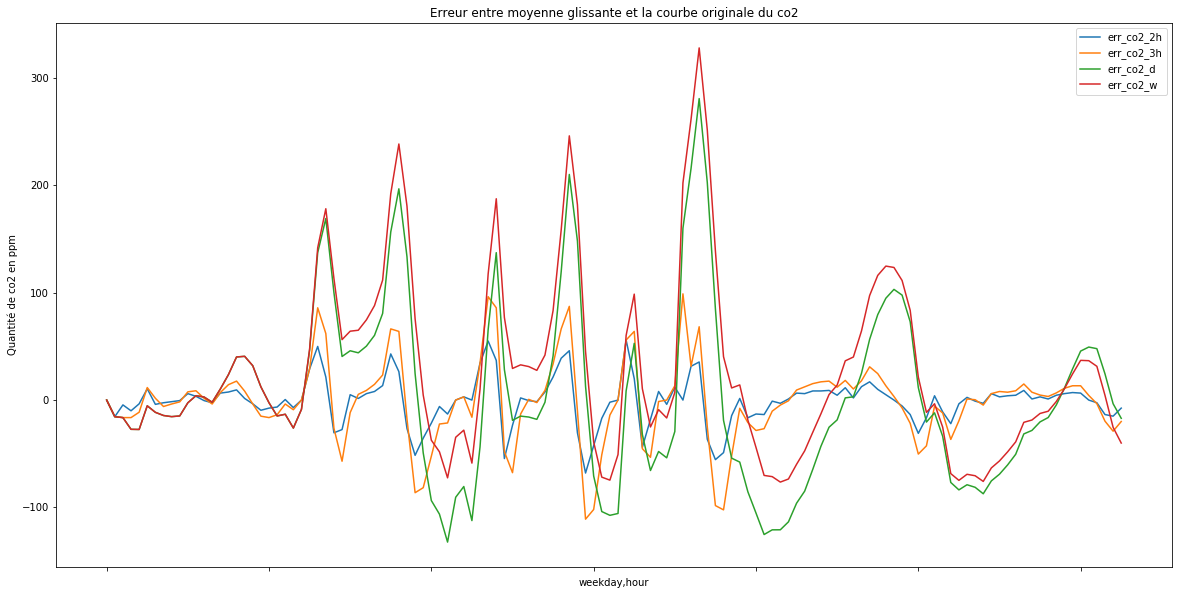

In [33]:
fig, ax = plt.subplots(figsize=(20,10))
ax.set_title("Erreur entre moyenne glissante et la courbe originale du co2")
ax.set_xlabel("Jour de la semaine et heure")
ax.set_ylabel("Quantité de co2 en ppm")
data_2013[data_2013["week"] == 1].plot(x = ['weekday','hour'],y = ['err_' +OUT + '_2h','err_' +OUT + '_3h','err_' +OUT + '_d','err_' +OUT + '_w'], ax = ax)

In [34]:
data = data.set_index(data['datetime'])
data = data.sort_index()
data[OUT +'_2h'] = data[OUT].rolling(window = '2H',min_periods = 1).mean()
data[OUT +'_3h'] = data[OUT].rolling(window = '3H',min_periods = 1).mean()
data[OUT +'_d'] = data[OUT].rolling(window = '24H',min_periods = 1).mean()
data[OUT +'_w'] = data[OUT].rolling(window = '7d',min_periods = 1).mean()

###### Building sliding window

In [35]:
window = 24
source = OUT
lag =  24
for idx in range(lag,lag + window):
    data[source + '_'  + str(idx)] = data[source]
    data[source + '_' + str(idx)] = data[source + '_' + str(idx)].shift(idx)
    
# removing the nans at the start
data = data.iloc[window+lag:,:]

###### Pairplot

In [36]:
data_corr = data[['frequentation','year','month','day','hour','weekday','week','precipitation','temp_min','temp_max',OUT,OUT + '_3h',OUT + '_d',OUT + '_w','celebration','holiday']]

In [37]:
data_corr.columns

Index(['frequentation', 'year', 'month', 'day', 'hour', 'weekday', 'week',
       'precipitation', 'temp_min', 'temp_max', 'co2', 'co2_3h', 'co2_d',
       'co2_w', 'celebration', 'holiday'],
      dtype='object')

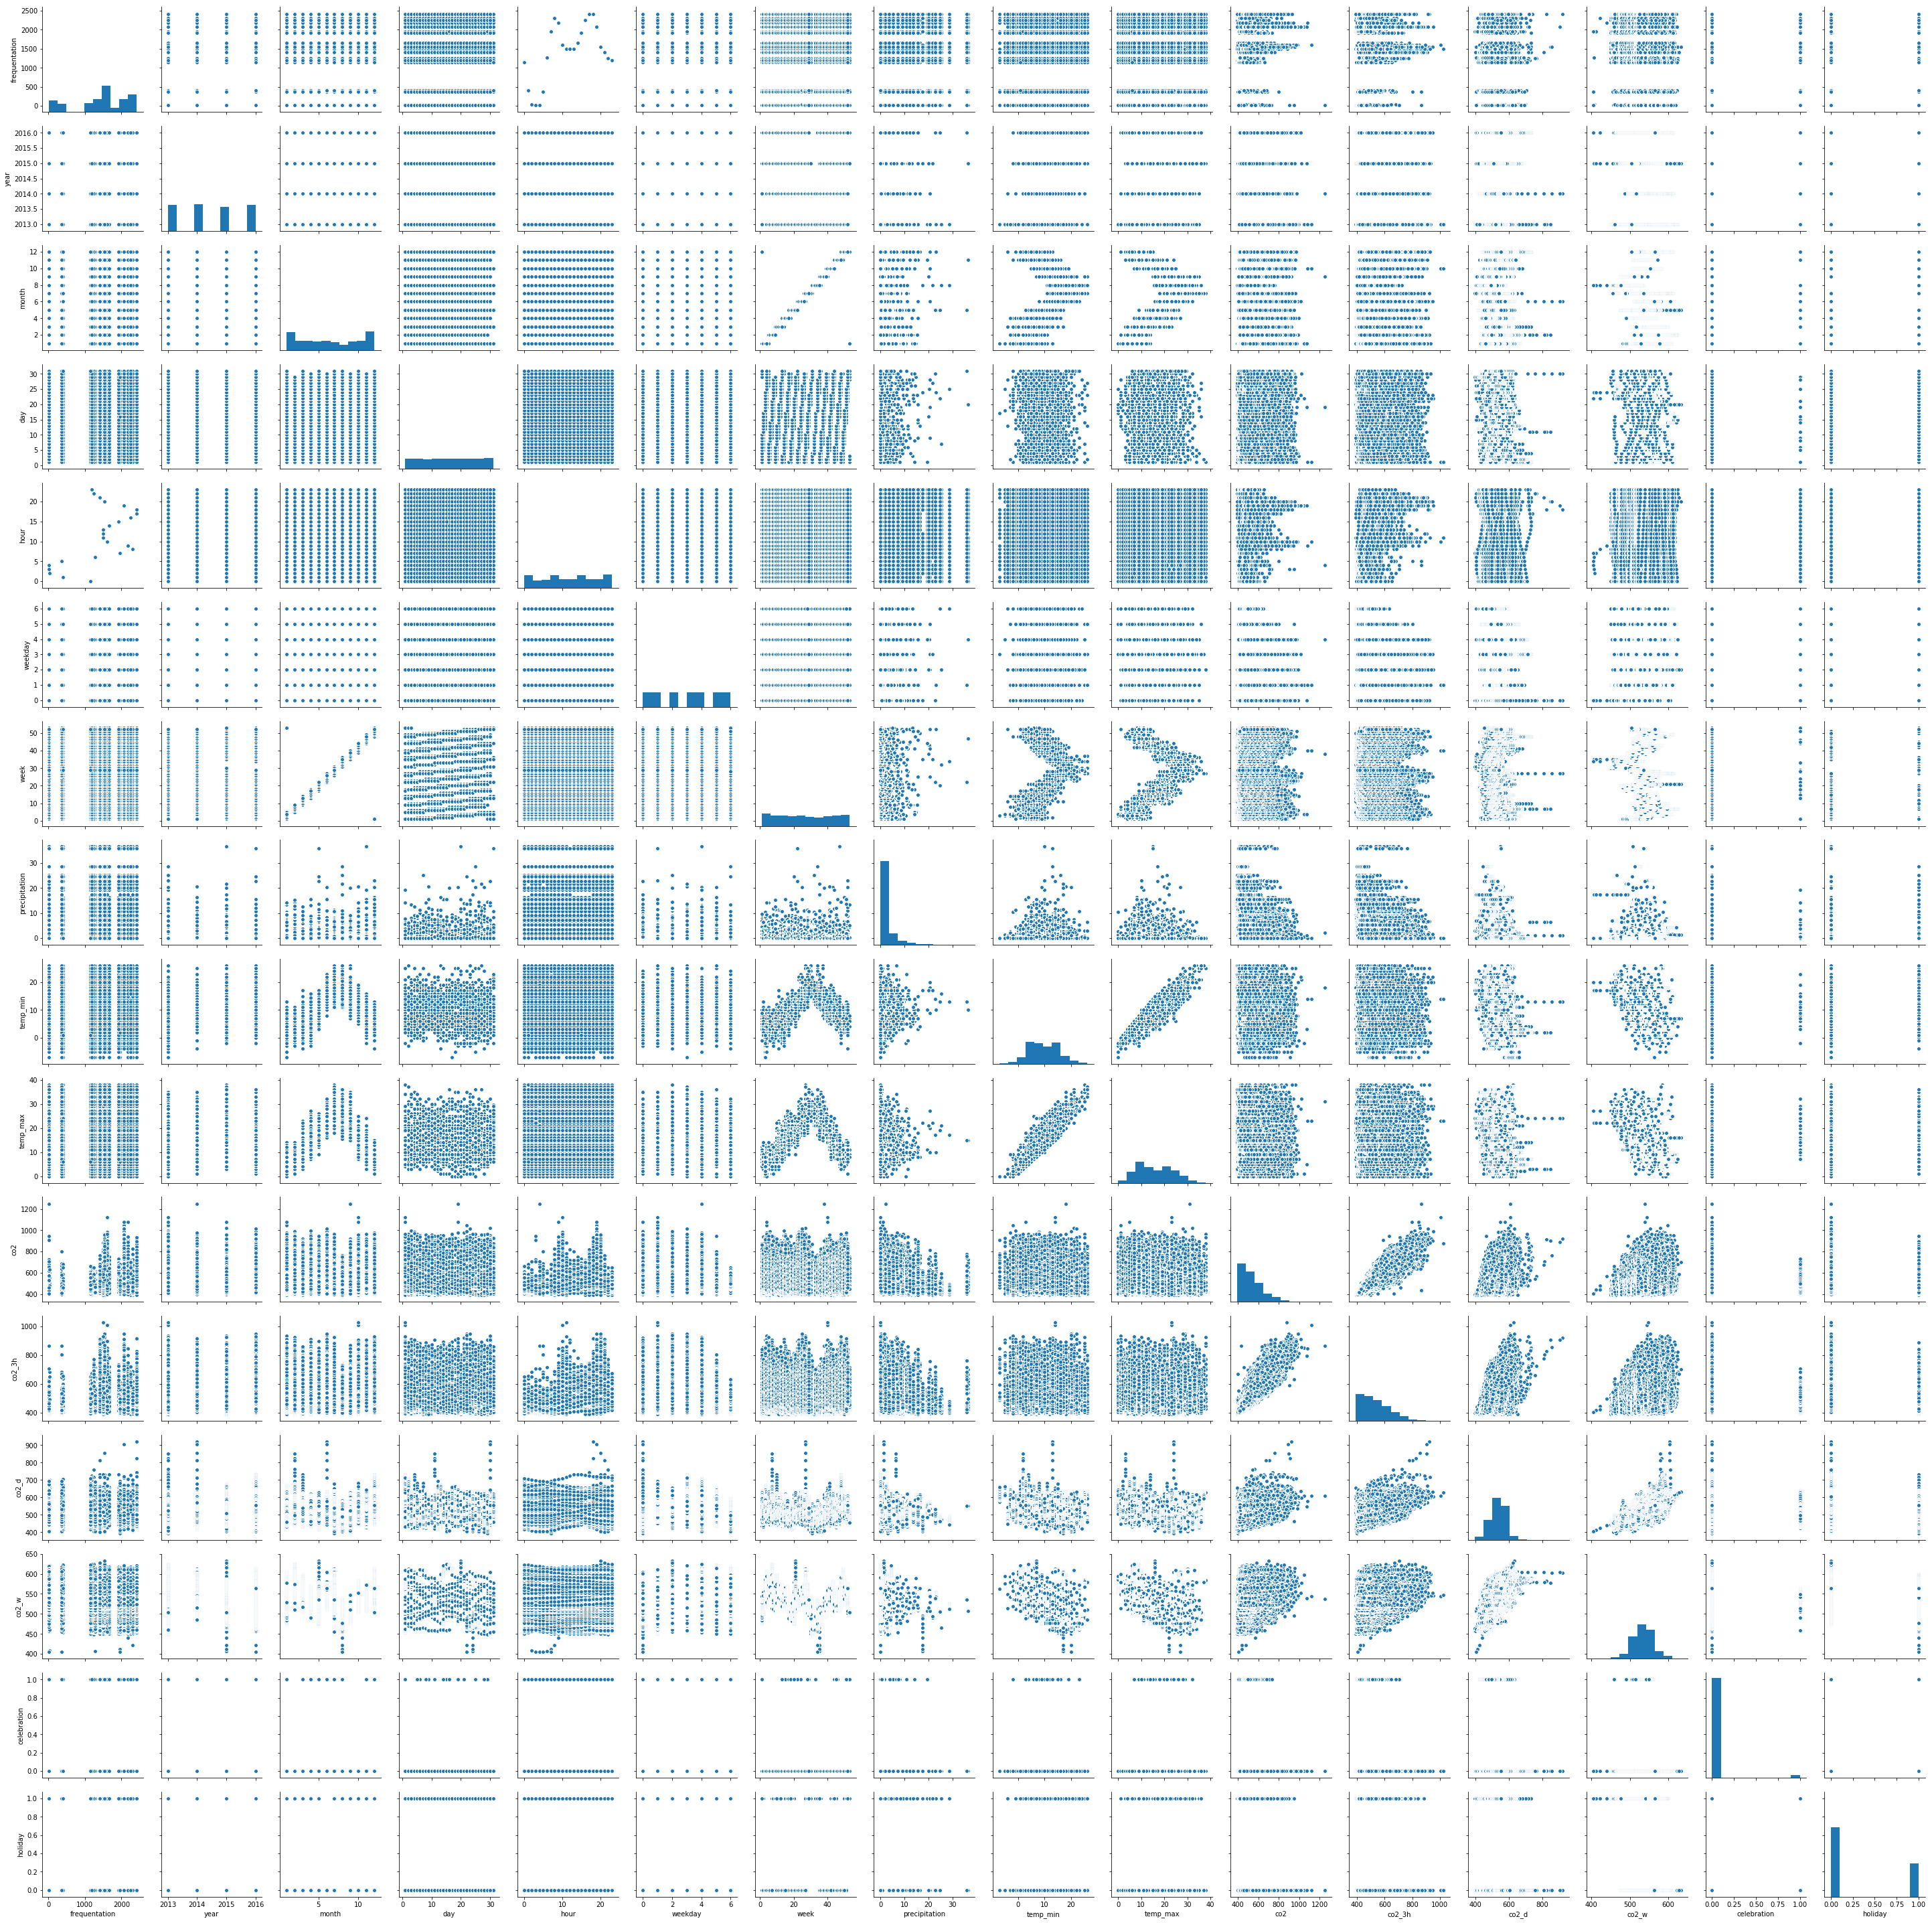

In [42]:
if not SKIP_PLOT:
    sns.pairplot(data_corr)

###### Correlations

In [43]:
if not SKIP_PLOT:
    corr = data_corr.corr()

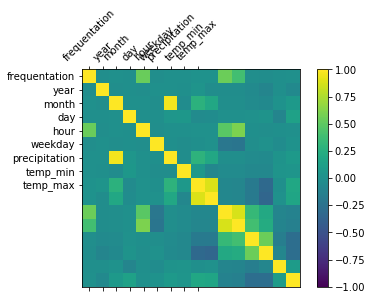

In [44]:
if not SKIP_PLOT:
    # plot correlation matrix
    fig = plt.figure()
    ax = fig.add_subplot(111)
    cax = ax.matshow(corr, vmin=-1, vmax=1)
    fig.colorbar(cax)
    ticks = np.arange(0,9,1)
    ax.set_xticks(ticks)
    ax.set_yticks(ticks)

    names = ['frequentation', 'year', 'month','day', 'hour', 'weekday', 'precipitation', 'temp_min','temp_max',OUT + '_d',OUT + '_w',OUT,'celebration','holiday']
    ax.set_xticklabels(names, rotation = 45)
    ax.set_yticklabels(names)
    plt.show()

## Feature engineering

In [45]:
data[OUT + '_log'] = data[OUT].apply(lambda x:np.log(x))
data[OUT + '_2h_log'] = data[OUT +'_2h'].apply(lambda x:np.log(x))
data[OUT + '_3h_log'] = data[OUT +'_3h'].apply(lambda x:np.log(x))
data[OUT + '_d_log'] = data[OUT +'_d'].apply(lambda x:np.log(x))
data[OUT + '_w_log'] = data[OUT +'_w'].apply(lambda x:np.log(x))
data['precipitation_log'] = data['precipitation'].apply(lambda x:np.log(x+0.001))

for i in range(lag,lag+window):
    data['co2_log'] = data[source + '_' + str(i)].apply(lambda x:np.log(x))

#### Normalization

In [46]:
from sklearn.preprocessing import StandardScaler
scalers = {}
features_to_scale = [OUT +'_log','frequentation',OUT +'_2h_log',OUT +'_3h_log',OUT +'_d_log',OUT +'_w_log',
                     'precipitation_log','temp_min','temp_max','a','b',
                     '1','11','14','3','4','7', '8','9'] + [source + '_' + str(i) for i in range(lag,lag + window)]


for feature in features_to_scale:
    scalers['feature'] = StandardScaler()
    scalers['feature'].fit_transform(data[feature].reshape(-1, 1))


/home/romain/.virtualenvs/python3.6/lib/python3.6/site-packages/ipykernel_launcher.py:10: FutureWarning: reshape is deprecated and will raise in a subsequent release. Please use .values.reshape(...) instead
  # Remove the CWD from sys.path while we load stuff.


## Modelization

In [47]:


features = ['year','month','day','hour', 'weekday', 'precipitation','temp_min','temp_max','celebration','holiday']
if USE_FREQ:
    features += ['frequentation']
else:
    features += ['a','b','1','11','14','3','4','7', '8','9']

if USE_SLIDING_WINDOW:
    features += [source +'_' + str(i) for i in range(lag,lag+window)]

In [48]:
X = data[features].values
Y = data['co2'].values.reshape(-1,1)
X_index = data['datetime']

In [49]:
data[features].columns

Index(['year', 'month', 'day', 'hour', 'weekday', 'precipitation', 'temp_min',
       'temp_max', 'celebration', 'holiday', 'a', 'b', '1', '11', '14', '3',
       '4', '7', '8', '9'],
      dtype='object')

In [50]:
from sklearn.model_selection import train_test_split
from sklearn import linear_model
from sklearn import ensemble

In [51]:
cv_ratio = 0.8

In [52]:
X_train, X_test, Y_train, Y_test, index_train, index_test = train_test_split(X,Y, X_index, random_state = SEED)

###### Baseline

In [53]:
from sklearn.metrics import r2_score

Simply use the mean of co2 as average

In [54]:
mean = np.average(Y_train)

In [55]:
Y_baseline_1 = np.full(Y_test.shape,mean)

In [56]:
baseline_1 = r2_score(Y_test,Y_baseline_1)

In [57]:
print(baseline_1)

-0.0001949802114071808


#### Ridge Regression

In [58]:
clf = linear_model.Lasso(alpha = 0.1)
clf.fit(X_train,Y_train)
clf.score(X_test,Y_test)

0.4284146357844483

In [59]:
for idx in range(len(features)):
    print(features[idx],clf.coef_[idx])

year -1.4802944157042262
month 0.16155354884916795
day 0.19505366956527911
hour 3.6622739236936783
weekday -11.024226054881275
precipitation -0.906625896196636
temp_min -0.3660687391339765
temp_max -0.7000671170019925
celebration -50.62702860396979
holiday -22.36444828724127
a -0.16174224340949528
b 0.0
1 0.0
11 0.0
14 0.0
3 0.07147109645946874
4 0.0
7 -0.5692186878486467
8 -0.11542566037085329
9 0.7367240243957595


#### ElasticNet Regression

In [60]:
clf = linear_model.ElasticNet(alpha = 0.1)
clf.fit(X_train,Y_train)
clf.score(X_test,Y_test)

0.4256149357133968

In [61]:
coeff = []
for idx in range(len(features)):
    print(features[idx],clf.coef_[idx])
    coeff += [[features[idx],clf.coef_[idx]]]

print(sorted(coeff, key = lambda x: abs(x[1])))

year -1.4224805393476172
month 0.10938154634317179
day 0.2316971643915848
hour 3.6561884910253557
weekday -10.848017500293878
precipitation -1.0143183074745026
temp_min -0.2838111826541548
temp_max -0.7980385660002197
celebration -19.2884505829886
holiday -19.3105032378396
a -0.16543376019144354
b 0.0
1 0.0
11 0.0
14 0.0
3 0.07154760493332649
4 0.0
7 -0.5704811432661944
8 -0.11425773280668075
9 0.7376780165386946
[['b', 0.0], ['1', 0.0], ['11', 0.0], ['14', 0.0], ['4', 0.0], ['3', 0.07154760493332649], ['month', 0.10938154634317179], ['8', -0.11425773280668075], ['a', -0.16543376019144354], ['day', 0.2316971643915848], ['temp_min', -0.2838111826541548], ['7', -0.5704811432661944], ['9', 0.7376780165386946], ['temp_max', -0.7980385660002197], ['precipitation', -1.0143183074745026], ['year', -1.4224805393476172], ['hour', 3.6561884910253557], ['weekday', -10.848017500293878], ['celebration', -19.2884505829886], ['holiday', -19.3105032378396]]


#### Random Forest Regression

In [62]:
clf = ensemble.RandomForestRegressor(n_estimators = 1000)
clf.fit(X_train,Y_train)
clf.score(X_test,Y_test)

/home/romain/.virtualenvs/python3.6/lib/python3.6/site-packages/ipykernel_launcher.py:2: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  


0.9064516000801499

In [63]:
for idx in range(len(features)):
    print(features[idx],clf.feature_importances_[idx])

year 0.015630723538287542
month 0.029530925032903013
day 0.027547564085515487
hour 0.46757514762711605
weekday 0.15926766701432063
precipitation 0.018970824333481816
temp_min 0.020565102244092574
temp_max 0.028629236361953657
celebration 0.024868760793073992
holiday 0.017792353818460612
a 0.01401728638652458
b 0.0
1 0.0
11 0.0
14 0.0
3 0.12941334540958055
4 0.0
7 0.01327659767999074
8 0.01651004099073348
9 0.016404424683965205


###### Modélisation 2

In [64]:
features = ['year','month','day','hour', 'weekday', 'precipitation','temp_min','temp_max','celebration','holiday']
if USE_FREQ:
    features += ['frequentation']
else:
    features += ['a','3','7', '8','9']

if USE_SLIDING_WINDOW:
    features += [source +'_' + str(i) for i in range(lag,window)]

In [65]:
X = data[features].values
out = data[OUT]
if USE_ROLLING_MEAN:
    Y = data[OUT+'_2h'].values.reshape(-1,1)
else:
    Y = data[OUT].values.reshape(-1,1)
X_index = data['datetime']

In [66]:
cv_ratio = 0.8

In [67]:
X_train, X_test, Y_train, Y_test, index_train, index_test, out_train,out_test = train_test_split(X,Y, X_index, out, random_state = SEED)

In [68]:
clf = ensemble.RandomForestRegressor(n_estimators = 1000)
clf.fit(X_train,Y_train)
clf.score(X_test,Y_test)

/home/romain/.virtualenvs/python3.6/lib/python3.6/site-packages/ipykernel_launcher.py:2: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  


0.9065185270771616

In [69]:
clf.score(X_test,out_test)

0.9065185270771616

In [70]:
test = pd.DataFrame(X_test,columns = features)
test['pred'] = clf.predict(X_test)
test['true'] = Y_test

In [71]:
test.head()

,year,month,day,hour,weekday,precipitation,temp_min,temp_max,celebration,holiday,a,3,7,8,9,pred,true
0,2015.0,11.0,28.0,10.0,5.0,3.1,3.0,8.0,0.0,0.0,95.0,777.0,331.0,339.0,402.0,493.985,515.0
1,2014.0,11.0,10.0,15.0,0.0,0.0,9.0,13.0,0.0,0.0,94.0,953.0,409.0,389.0,456.0,534.146,524.0
2,2013.0,9.0,22.0,22.0,6.0,0.0,16.0,26.0,0.0,0.0,64.0,609.0,250.0,270.0,322.0,446.380,422.0
3,2016.0,2.0,1.0,12.0,0.0,0.3,11.0,13.0,0.0,0.0,94.0,689.0,327.0,335.0,388.0,533.670,534.0
4,2015.0,3.0,19.0,4.0,3.0,0.4,5.0,9.0,0.0,0.0,0.0,0.0,0.0,0.0,18.0,418.777,415.0


In [72]:
test['datetime'] = pd.to_datetime(test[['year','month','day','hour']])

In [74]:
test['pred'] = test['pred'].round()

/home/romain/.virtualenvs/python3.6/lib/python3.6/site-packages/pandas/plotting/_core.py:1716: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  series.name = label


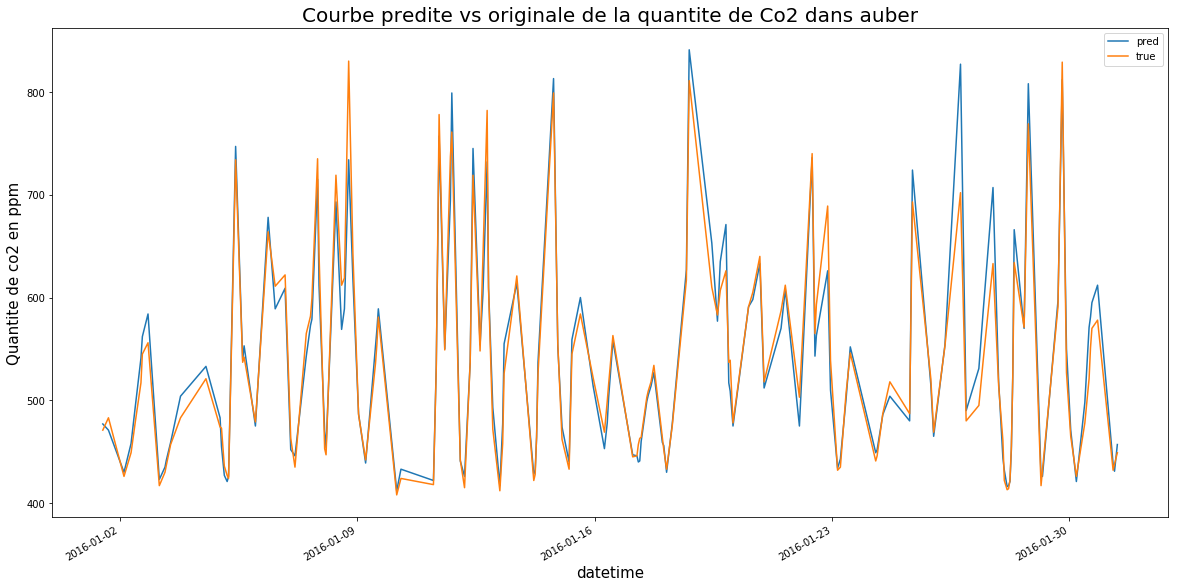

In [75]:
fig, ax = plt.subplots(figsize=(20,10))
index = (test['year'] == 2016) & (test['month'] == 1)
ax.set_title("Courbe predite vs originale de la quantite de Co2 dans auber", size = 20)
ax.set_xlabel("Data et heure", size =15)
ax.set_ylabel("Quantite de co2 en ppm", size =15)

test.loc[index,:].plot(x = ['datetime'], y=['pred','true'], ax = ax)

In [76]:
from sklearn.model_selection import GridSearchCV

###### Grid search random forest

In [77]:
clf = ensemble.RandomForestRegressor(n_jobs=4)

In [78]:
param_grid = {
    "n_estimators":[100,1000,5000],
    "min_samples_split":[2,3],
    "min_samples_leaf":[1,2]
}

In [79]:
gridcv = GridSearchCV(clf,param_grid)

In [80]:
gridcv.fit(X,Y)

/home/romain/.virtualenvs/python3.6/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/home/romain/.virtualenvs/python3.6/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/home/romain/.virtualenvs/python3.6/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/home/romain/.virtualenvs/python3.6/lib/python3.6/site-packages/skl

/home/romain/.virtualenvs/python3.6/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/home/romain/.virtualenvs/python3.6/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/home/romain/.virtualenvs/python3.6/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/home/romain/.virtualenvs/python3.6/lib/python3.6/site-packages/skl

GridSearchCV(cv=None, error_score='raise',
       estimator=RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=4,
           oob_score=False, random_state=None, verbose=0, warm_start=False),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'n_estimators': [100, 1000, 5000], 'min_samples_split': [2, 3], 'min_samples_leaf': [1, 2]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

In [81]:
gridcv.best_params_

{'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 5000}

param_grid = {
    "n_estimators":[100,200,300,400],
    "min_samples_split":[2,3],
    "min_samples_leaf":[1,2]
}
best : {'min_samples_leaf': 2, 'min_samples_split': 3, 'n_estimators': 400}

In [82]:
gridcv.best_score_

0.8250045882685398